## Gait Video Project
### Ablation Study on Subject generalization framework with Traditional ML models only 
* We will explore the performance of using feet coordinates only (merged from both front and side camera views), feet + ankle coordinates (merged from both front and side camera views), feet + ankle (merged from both front and side camera views) + knee (from the single front camera view) coordinates and all (feet + ankle (merged from both front and side camera views) + knee + hip (from the single front camera view)) coordinates on the traditional ML models.
* In our main traditional models, total 91 features (including the frame count and 90 CoV, range and asymmetry of the body coordinate features) were used.

In [67]:
from importlib import reload
from ml_utils.imports import *

from ml_utils import subject_gen_traditionalML
reload(subject_gen_traditionalML)
from ml_utils.subject_gen_traditionalML import keep_common_PIDs, models, evaluate, run_ml_models
from ml_utils.subject_gen_traditionalML import design
from ast import literal_eval

In [54]:
path = 'C:\\Users\\Rachneet Kaur\\Box\\Gait Video Project\\GaitVideoData\\video\\'
data_path = path+'traditional_methods_dataframe.csv'
results_path = 'C:\\Users\\Rachneet Kaur\\Box\Gait Video Project\\AblationResults\\ML\\'

data = pd.read_csv(data_path, index_col= 0)
display(data.head())

#Whether to save the results (confusion matrices and RoC plots) or not 
save_results = True 

,key,cohort,trial,scenario,video,PID,stride_number,frame_count,label,right hip-x-CoV,...,ankle-z-asymmetry,heel-x-asymmetry,heel-y-asymmetry,heel-z-asymmetry,toe 1-x-asymmetry,toe 1-y-asymmetry,toe 1-z-asymmetry,toe 2-x-asymmetry,toe 2-y-asymmetry,toe 2-z-asymmetry
0,GVS_212_T_T1_1,HOA,BW,SLWT,GVS_212_T_T1,212,1,46,0,0.046077,...,14.426173,3.407379,10.662441,0.830365,0.502570,31.450487,8.644012,5.236678,31.182183,8.215725
1,GVS_212_T_T1_2,HOA,BW,SLWT,GVS_212_T_T1,212,2,39,0,0.021528,...,1.360847,5.155307,11.363806,4.333776,1.025647,28.266400,2.671081,6.678294,15.058825,4.903579
2,GVS_212_T_T1_3,HOA,BW,SLWT,GVS_212_T_T1,212,3,56,0,0.034394,...,1.341021,8.625363,7.159495,3.366152,1.759968,17.545787,5.921325,8.243491,9.578638,3.008162
3,GVS_212_T_T1_4,HOA,BW,SLWT,GVS_212_T_T1,212,4,53,0,0.028511,...,2.375934,6.728268,0.098235,0.999027,0.541911,7.843339,4.279617,0.748023,19.471731,5.086056
4,GVS_212_T_T1_5,HOA,BW,SLWT,GVS_212_T_T1,212,5,44,0,0.025213,...,8.525816,1.775282,0.033210,9.166863,1.354601,6.674183,8.479480,4.373622,0.315168,11.795593


### Subject generalization framework 1: walking (W) to classify HOA/MS/PD strides and subjects using cross validation 

In [55]:
#Trial W for the first framework of subject generalization
trialW = data[data['scenario']=='W']
print ('Original number of subjects in trial W for cross validation:', len(trialW['PID'].unique()))
print ('Number of subjects in trial W in each cohort:\n', trialW.groupby('PID').first()['cohort'].value_counts())

cols_to_drop = ['PID', 'key', 'cohort', 'trial', 'scenario', 'video', 'stride_number', 'label']
#Shuffling the cross validation stride data
trialW = shuffle(trialW, random_state = 0)
#CV for people generalize so no train-test split
X = trialW.drop(cols_to_drop, axis = 1)
Y = trialW[['PID', 'label']]

#Total strides and imbalance of labels in the training and testing set
#Training set 
print('Strides in trial W for cross validation: ', len(trialW))
print ('HOA, MS and PD strides in trial W:\n', trialW['cohort'].value_counts())
print ('Imbalance ratio in trial W (controls:MS:PD)= 1:X:Y\n', trialW['cohort'].value_counts()/trialW['cohort'].value_counts()['HOA'])

#Defining the framework of interest
framework = 'W'

Original number of subjects in trial W for cross validation: 32
Number of subjects in trial W in each cohort:
 HOA    14
MS     10
PD      8
Name: cohort, dtype: int64
Strides in trial W for cross validation:  1380
HOA, MS and PD strides in trial W:
 HOA    658
MS     389
PD     333
Name: cohort, dtype: int64
Imbalance ratio in trial W (controls:MS:PD)= 1:X:Y
 HOA    1.000000
MS     0.591185
PD     0.506079
Name: cohort, dtype: float64


In [56]:
ml_models = ['logistic_regression', 'random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'decision_tree',  \
             'linear_svm', 'mlp']

feet_features = [s for s in data.columns if any(x in s for x in ['toe', 'heel'])]
print ('Number of feet features = ', len(feet_features))

ankle_features = [s for s in data.columns if 'ankle' in s]
print ('Number of ankle features = ', len(ankle_features))

knee_features = [s for s in data.columns if 'knee' in s]
print ('Number of knee features = ', len(knee_features))

hip_features = [s for s in data.columns if 'hip' in s]
print ('Number of hip features = ', len(hip_features))

frame_count_feature = ['frame_count']
print ('The extra frame count feature is added to all datastreams')

#The three extra data streams we would need to run for (assuming we already have the results for the 
#fourth feet+ankle+knee+hip+frame count = All features)
datastreams = {'feet': feet_features + frame_count_feature, 'feet+ankle': feet_features + ankle_features + frame_count_feature, \
               'feet+ankle+knee': feet_features + ankle_features + knee_features + frame_count_feature}

print ('No. of features explored in each datastream: ', {x:len(datastreams[x]) for x in datastreams})
ablation_columns = list(itertools.product(ml_models,datastreams))
metrics = pd.DataFrame(columns = ablation_columns) #Dataframe to store accuracies for each ML model for raw data 

Number of feet features =  45
Number of ankle features =  15
Number of knee features =  15
Number of hip features =  15
The extra frame count feature is added to all datastreams
No. of features explored in each datastream:  {'feet': 46, 'feet+ankle': 61, 'feet+ankle+knee': 76}


feet
logistic_regression
best_params:  {'logisticregression__random_state': 0}

Stride-based model performance (mean):  [0.5116532860962513, 0.47233025108530863, 0.5116532860962513, 0.5193551060883939, [0.610643096785483, 0.45982417722970526, 0.3465234792407375], 0.4484825068160162, 0.5116532860962513, 0.5116532860962513, [0.700551995048556, 0.4504854460577352, 0.19441007934175727], 0.4465870770476797, 0.5116532860962513, 0.5025271980604432, [0.6476170770249009, 0.4471733552200666, 0.2449707988980716], 0.6349294061090333, 0.6427144381641977]

Stride-based model performance (standard deviation):  [0.06809330723676121, 0.037290535875964155, 0.06809330723676121, 0.05583607891794428, [0.10811757482160876, 0.17103494994957302, 0.20517156076390838], 0.04727390556083375, 0.06809330723676121, 0.06809330723676121, [0.15604660936278866, 0.06925818240194662, 0.08151880453489954], 0.03912548808177191, 0.06809330723676121, 0.06440500140777133, [0.109380324694748, 0.11192998447297933, 0.122269027179

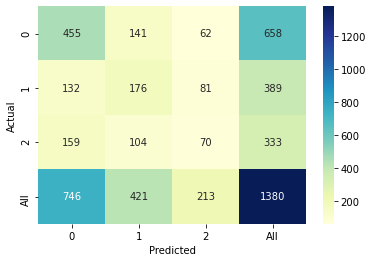

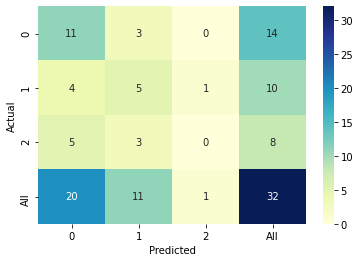

<Figure size 432x288 with 0 Axes>

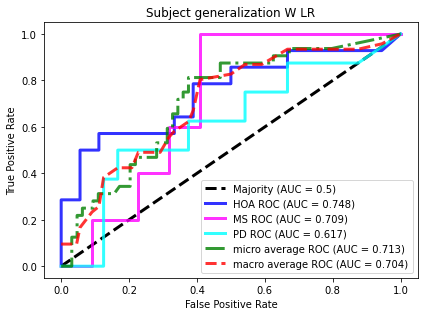

********************************
decision_tree
best_params:  {'decisiontreeclassifier__min_samples_split': 49}

Stride-based model performance (mean):  [0.5617362945428699, 0.5469407800952457, 0.5617362945428699, 0.5906723635555122, [0.6912668996620039, 0.46501444622792937, 0.48454099439580384], 0.5338827723233083, 0.5617362945428699, 0.5617362945428699, [0.6212341349260536, 0.5635479810981818, 0.4168662009456896], 0.5296024506997685, 0.5617362945428699, 0.5674934952748547, [0.6523861394917645, 0.5020940644606064, 0.4343271481469347], 0.6629731787834838, 0.6725348869915889]

Stride-based model performance (standard deviation):  [0.08556049205416803, 0.08654648676469877, 0.08556049205416803, 0.10787099318027199, [0.15974537848804574, 0.1528067908736663, 0.17844837997814555], 0.07734815383989635, 0.08556049205416803, 0.08556049205416803, [0.13119015382746957, 0.11895486327668951, 0.12236732243129597], 0.07425459337122979, 0.08556049205416803, 0.09153845444633929, [0.13687703361851694, 0.

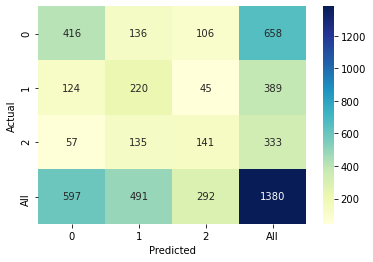

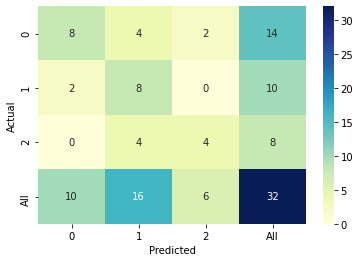

<Figure size 432x288 with 0 Axes>

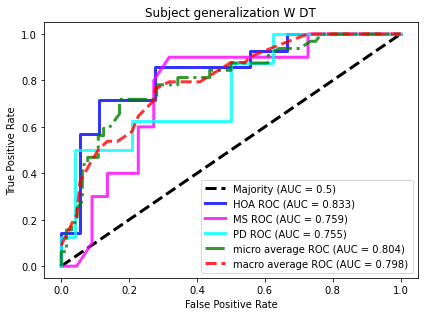

********************************
********************************
feet+ankle
logistic_regression
best_params:  {'logisticregression__random_state': 0}

Stride-based model performance (mean):  [0.5392946990162288, 0.504767121847074, 0.5392946990162288, 0.5434085669033534, [0.6152964704214704, 0.46508523785819306, 0.4339196572615583], 0.4841944910089193, 0.5392946990162288, 0.5392946990162288, [0.6939293705111117, 0.4739419501367293, 0.284712152378917], 0.48379785094485506, 0.5392946990162288, 0.5313298383748535, [0.6476451480118265, 0.46349563818510003, 0.3402527666376387], 0.6657147670943322, 0.668958947598464]

Stride-based model performance (standard deviation):  [0.07500349382834563, 0.03604625493180981, 0.07500349382834563, 0.06451144004826041, [0.10648006100847215, 0.18207530566356855, 0.15868587079721277], 0.04092724869596338, 0.07500349382834563, 0.07500349382834563, [0.1466075761247119, 0.13671647548083338, 0.08200189987945007], 0.04200445595808435, 0.07500349382834563, 0.07432

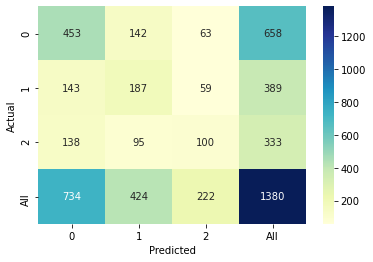

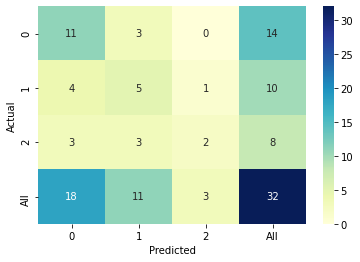

<Figure size 432x288 with 0 Axes>

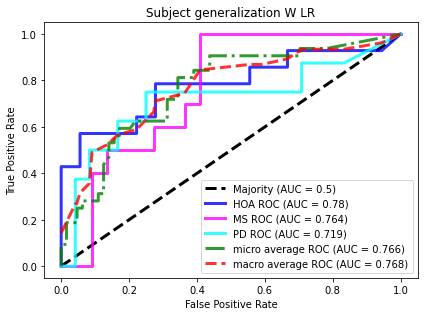

********************************
decision_tree
best_params:  {'decisiontreeclassifier__min_samples_split': 43}

Stride-based model performance (mean):  [0.5308044865591335, 0.5020094261038025, 0.5308044865591335, 0.5547174838887774, [0.6690790663976718, 0.4402477427960157, 0.39670146911772003], 0.5007365592026952, 0.5308044865591335, 0.5308044865591335, [0.6105530068317656, 0.5204722880124487, 0.37118438276387145], 0.4892721609319427, 0.5308044865591335, 0.5331537842763143, [0.6361570446654817, 0.46956101024244457, 0.3620984278879016], 0.6588744406916313, 0.6664810278219898]

Stride-based model performance (standard deviation):  [0.08340325838373583, 0.10616322782134671, 0.08340325838373583, 0.10830969659532365, [0.16633266916651343, 0.11755583157693998, 0.2509493896253871], 0.09813700017349407, 0.08340325838373583, 0.08340325838373583, [0.09054687457092121, 0.11407231032651302, 0.24865347029065432], 0.09591849353937755, 0.08340325838373583, 0.09127196770283343, [0.12345181612842324, 0

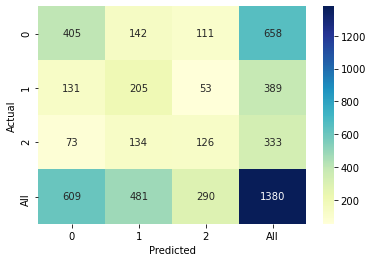

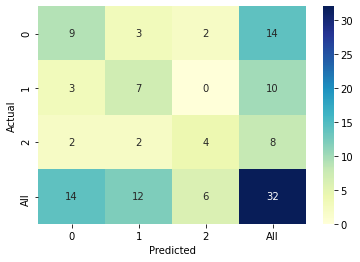

<Figure size 432x288 with 0 Axes>

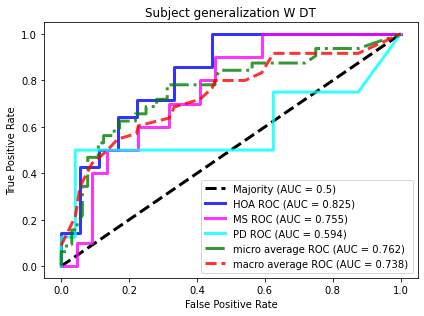

********************************
********************************
feet+ankle+knee
logistic_regression
best_params:  {'logisticregression__random_state': 0}

Stride-based model performance (mean):  [0.5509259712568536, 0.5420565315687512, 0.5509259712568536, 0.57241308754102, [0.6310631815864066, 0.5334820412867466, 0.4616243718331005], 0.5312427707881786, 0.5509259712568536, 0.5509259712568536, [0.6486474201955351, 0.5198870124372132, 0.42519387973178746], 0.5206034664291829, 0.5509259712568536, 0.5477766021470727, [0.6331259958436816, 0.5182499491494338, 0.4104344542944331], 0.7148939980732767, 0.7122699141478706]

Stride-based model performance (standard deviation):  [0.08203161248755424, 0.07575961620747063, 0.08203161248755424, 0.09697501143609781, [0.12581599221769343, 0.1646240487942851, 0.1052394925153504], 0.07299188184003173, 0.08203161248755424, 0.08203161248755424, [0.1503411002386081, 0.07866306139740065, 0.17476741858832223], 0.07093425140268186, 0.08203161248755424, 0.087

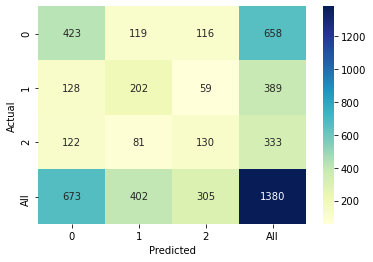

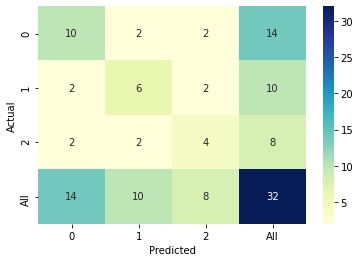

<Figure size 432x288 with 0 Axes>

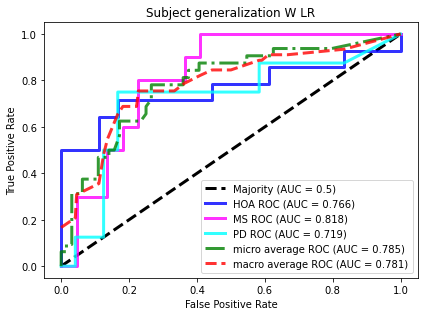

********************************
decision_tree
best_params:  {'decisiontreeclassifier__min_samples_split': 41}

Stride-based model performance (mean):  [0.552431565485874, 0.523475025581894, 0.552431565485874, 0.5627743879577961, [0.6456621872244801, 0.4406732874968169, 0.48408960202438467], 0.5114195769724093, 0.552431565485874, 0.552431565485874, [0.7050306489822208, 0.38473772583210336, 0.4444903561029038], 0.5048833541699165, 0.552431565485874, 0.5476031049196527, [0.6697295539485032, 0.4063994808063441, 0.4385210277549021], 0.657367547028216, 0.6657754245372374]

Stride-based model performance (standard deviation):  [0.07326112444199018, 0.06406263614442786, 0.07326112444199018, 0.08638317692093374, [0.13366756692826245, 0.18461571660067402, 0.1332704863641986], 0.07779315044193519, 0.07326112444199018, 0.07326112444199018, [0.13387948749819273, 0.10126691752818218, 0.21017746307034926], 0.06089264672761367, 0.07326112444199018, 0.07331682185168384, [0.11454386292698084, 0.1325368

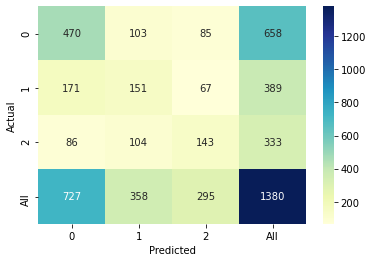

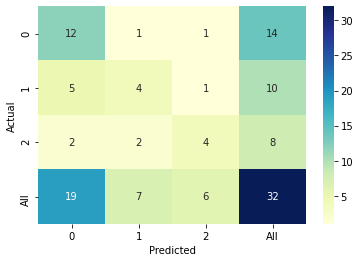

<Figure size 432x288 with 0 Axes>

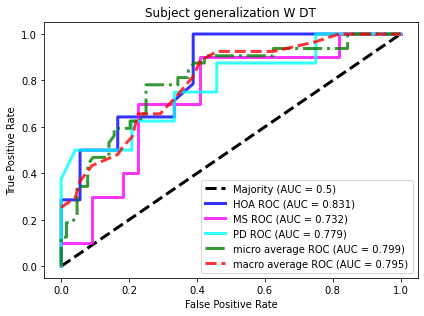

********************************
********************************


In [57]:
for col in datastreams:
    print (col)
    datastream = datastreams[col]
#     print (regressN_trainX_norm[datastream].head())
    stride_person_metrics = run_ml_models(ml_models, X[datastream], Y, framework, results_path, save_results, col)
    for i in stride_person_metrics.columns:
        metrics[(i, col)] = stride_person_metrics[i]
    print ('********************************')

if save_results:
    metrics.to_csv(results_path+ framework + '\\subject_generalize_ablation_study_'+framework+'_result_metrics.csv')

In [58]:
metrics

,"(logistic_regression, feet)","(logistic_regression, feet+ankle)","(logistic_regression, feet+ankle+knee)","(decision_tree, feet)","(decision_tree, feet+ankle)","(decision_tree, feet+ankle+knee)"
stride_accuracy_mean,0.511653,0.539295,0.550926,0.561736,0.530804,0.552432
stride_precision_macro_mean,0.472330,0.504767,0.542057,0.546941,0.502009,0.523475
stride_precision_micro_mean,0.511653,0.539295,0.550926,0.561736,0.530804,0.552432
stride_precision_weighted_mean,0.519355,0.543409,0.572413,0.590672,0.554717,0.562774
stride_precision_class_wise_mean,"[0.610643096785483, 0.45982417722970526, 0.346...","[0.6152964704214704, 0.46508523785819306, 0.43...","[0.6310631815864066, 0.5334820412867466, 0.461...","[0.6912668996620039, 0.46501444622792937, 0.48...","[0.6690790663976718, 0.4402477427960157, 0.396...","[0.6456621872244801, 0.4406732874968169, 0.484..."
stride_recall_macro_mean,0.448483,0.484194,0.531243,0.533883,0.500737,0.511420
stride_recall_micro_mean,0.511653,0.539295,0.550926,0.561736,0.530804,0.552432
stride_recall_weighted_mean,0.511653,0.539295,0.550926,0.561736,0.530804,0.552432
stride_recall_class_wise_mean,"[0.700551995048556, 0.4504854460577352, 0.1944...","[0.6939293705111117, 0.4739419501367293, 0.284...","[0.6486474201955351, 0.5198870124372132, 0.425...","[0.6212341349260536, 0.5635479810981818, 0.416...","[0.6105530068317656, 0.5204722880124487, 0.371...","[0.7050306489822208, 0.38473772583210336, 0.44..."
stride_F1_macro_mean,0.446587,0.483798,0.520603,0.529602,0.489272,0.504883


### Reading the final metrics from the saved file

In [72]:
ablation_subject_generalizeW = pd.read_csv(results_path+ framework + '\\subject_generalize_ablation_study_'+framework+'_result_metrics.csv')
ablation_subject_generalizeW.index = ablation_subject_generalizeW['Unnamed: 0']
ablation_subject_generalizeW.drop('Unnamed: 0', axis = 1, inplace = True)

ablation_subject_generalizeW.columns = [literal_eval(ablation_subject_generalizeW.loc['person_accuracy_mean'].index[idx]) for idx in range(len(ablation_subject_generalizeW.loc['person_accuracy_mean'].index))]

In [73]:
ablation_subject_generalizeW

,"(logistic_regression, feet)","(logistic_regression, feet+ankle)","(logistic_regression, feet+ankle+knee)","(decision_tree, feet)","(decision_tree, feet+ankle)","(decision_tree, feet+ankle+knee)"
Unnamed: 0,,,,,,
stride_accuracy_mean,0.5116532860962513,0.5392946990162288,0.5509259712568536,0.5617362945428699,0.5308044865591335,0.552431565485874
stride_precision_macro_mean,0.47233025108530863,0.504767121847074,0.5420565315687512,0.5469407800952457,0.5020094261038025,0.523475025581894
stride_precision_micro_mean,0.5116532860962513,0.5392946990162288,0.5509259712568536,0.5617362945428699,0.5308044865591335,0.552431565485874
stride_precision_weighted_mean,0.5193551060883939,0.5434085669033534,0.57241308754102,0.5906723635555122,0.5547174838887774,0.5627743879577961
stride_precision_class_wise_mean,"[0.610643096785483, 0.45982417722970526, 0.346...","[0.6152964704214704, 0.46508523785819306, 0.43...","[0.6310631815864066, 0.5334820412867466, 0.461...","[0.6912668996620039, 0.46501444622792937, 0.48...","[0.6690790663976718, 0.4402477427960157, 0.396...","[0.6456621872244801, 0.4406732874968169, 0.484..."
stride_recall_macro_mean,0.4484825068160162,0.4841944910089193,0.5312427707881786,0.5338827723233083,0.5007365592026952,0.5114195769724093
stride_recall_micro_mean,0.5116532860962513,0.5392946990162288,0.5509259712568536,0.5617362945428699,0.5308044865591335,0.552431565485874
stride_recall_weighted_mean,0.5116532860962513,0.5392946990162288,0.5509259712568536,0.5617362945428699,0.5308044865591335,0.552431565485874
stride_recall_class_wise_mean,"[0.700551995048556, 0.4504854460577352, 0.1944...","[0.6939293705111117, 0.4739419501367293, 0.284...","[0.6486474201955351, 0.5198870124372132, 0.425...","[0.6212341349260536, 0.5635479810981818, 0.416...","[0.6105530068317656, 0.5204722880124487, 0.371...","[0.7050306489822208, 0.38473772583210336, 0.44..."


### Heatmap for person mean accuracy for all algorithms and data streams for Subject generalize in trial W

In [80]:
person_accuracy_subject_generlaizeW = pd.DataFrame(columns = ['random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'decision_tree',  'linear_svm', 
             'logistic_regression', 'mlp'], index = list(datastreams.keys()))


for idx in range(len(ablation_subject_generalizeW.columns)):
    x = ablation_subject_generalizeW.loc['person_accuracy_mean'].index[idx][1]
    y = ablation_subject_generalizeW.loc['person_accuracy_mean'].index[idx][0]
#     print (regressN_metrics.loc['person_accuracy'][(y, x)])
    person_accuracy_subject_generlaizeW.loc[x, y] = ablation_subject_generalizeW.loc['person_accuracy_mean'][(y, x)]

person_accuracy_subject_generlaizeW = person_accuracy_subject_generlaizeW.astype(float)

In [91]:
#Adding the person mean accuracy for all the models using all the features 
person_accuracy_subject_generlaizeW.loc['All features'] = [np.nan]*9

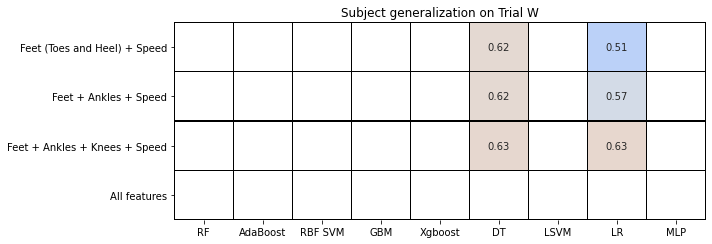

In [99]:
ml_model_names1 = ['RF','AdaBoost', 'RBF SVM', 'GBM','Xgboost', 'DT',  'LSVM', 'LR', 'MLP']
datasets = ['Feet (Toes and Heel) + Speed', 'Feet + Ankles + Speed', 'Feet + Ankles + Knees + Speed', 'All features']

fig, axes = plt.subplots(1, 1, figsize=(10, 3.5))
sns.heatmap(person_accuracy_subject_generlaizeW, vmin=0.3, vmax=1.0, center = 0.6, cmap="coolwarm", annot=True, linewidths=0.4, linecolor="k", \
            cbar = False, xticklabels=ml_model_names1,  yticklabels=datasets)
plt.title('Subject generalization on Trial W')
plt.tight_layout()
plt.savefig(results_path + framework + '\\subject_generalize_ablation_study_'+framework+'_heatmap.jpg', dpi = 250)
plt.show()

### Subject generalization framework 2: walking while talking (WT) to classify strides and subjects of HOA/MS/PD

In [74]:
#Trial WT for the second framework of subject generalization
trialWT = data[data['scenario']=='WT']
print ('Original number of subjects in trial WT for cross validation:', len(trialWT['PID'].unique()))
print ('Number of subjects in trial WT in each cohort:\n', trialWT.groupby('PID').first()['cohort'].value_counts())

cols_to_drop = ['PID', 'key', 'cohort', 'trial', 'scenario', 'video', 'stride_number', 'label']
#Shuffling the cross validation stride data
trialWT = shuffle(trialWT, random_state = 0)
#CV for people generalize so no train-test split
X_WT = trialWT.drop(cols_to_drop, axis = 1)
Y_WT = trialWT[['PID', 'label']]

#Total strides and imbalance of labels in the training and testing set
#Training set 
print('Strides in trial WT for cross validation: ', len(trialWT))
print ('HOA, MS and PD strides in trial WT:\n', trialWT['cohort'].value_counts())
print ('Imbalance ratio in trial WT (controls:MS:PD)= 1:X:Y\n', trialWT['cohort'].value_counts()/trialWT['cohort'].value_counts()['HOA'])
#Defining the framework of interest
framework = 'WT'

Original number of subjects in trial WT for cross validation: 26
Number of subjects in trial WT in each cohort:
 MS     9
PD     9
HOA    8
Name: cohort, dtype: int64
Strides in trial WT for cross validation:  1050
HOA, MS and PD strides in trial WT:
 PD     367
HOA    351
MS     332
Name: cohort, dtype: int64
Imbalance ratio in trial WT (controls:MS:PD)= 1:X:Y
 PD     1.045584
HOA    1.000000
MS     0.945869
Name: cohort, dtype: float64


In [75]:
ml_models = ['logistic_regression', 'random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'decision_tree',  \
             'linear_svm', 'mlp']

feet_features = [s for s in data.columns if any(x in s for x in ['toe', 'heel'])]
print ('Number of feet features = ', len(feet_features))

ankle_features = [s for s in data.columns if 'ankle' in s]
print ('Number of ankle features = ', len(ankle_features))

knee_features = [s for s in data.columns if 'knee' in s]
print ('Number of knee features = ', len(knee_features))

hip_features = [s for s in data.columns if 'hip' in s]
print ('Number of hip features = ', len(hip_features))

frame_count_feature = ['frame_count']
print ('The extra frame count feature is added to all datastreams')

#The three extra data streams we would need to run for (assuming we already have the results for the 
#fourth feet+ankle+knee+hip+frame count = All features)
datastreams = {'feet': feet_features + frame_count_feature, 'feet+ankle': feet_features + ankle_features + frame_count_feature, \
               'feet+ankle+knee': feet_features + ankle_features + knee_features + frame_count_feature}

print ('No. of features explored in each datastream: ', {x:len(datastreams[x]) for x in datastreams})
ablation_columns = list(itertools.product(ml_models,datastreams))
metrics_WT = pd.DataFrame(columns = ablation_columns) #Dataframe to store accuracies for each ML model for raw data 

Number of feet features =  45
Number of ankle features =  15
Number of knee features =  15
Number of hip features =  15
The extra frame count feature is added to all datastreams
No. of features explored in each datastream:  {'feet': 46, 'feet+ankle': 61, 'feet+ankle+knee': 76}


feet
logistic_regression
best_params:  {'logisticregression__random_state': 0}

Stride-based model performance (mean):  [0.3807142762988591, 0.4366167539075473, 0.3807142762988591, 0.464860689914065, [0.3362198685941135, 0.43661303630363035, 0.537017356824898], 0.3894224492169037, 0.3807142762988591, 0.3807142762988591, [0.3334593507585421, 0.3412987686003318, 0.49350922829183697], 0.36206256997498504, 0.3807142762988591, 0.36468046117882646, [0.3285608609911772, 0.31837025881626074, 0.4392565901175173], 0.5865168406930874, 0.5915403730232298]

Stride-based model performance (standard deviation):  [0.13286292203045727, 0.10680315619204211, 0.13286292203045727, 0.10520951523659966, [0.2592077426210226, 0.279560475748365, 0.18327805846946565], 0.13110842044946602, 0.13286292203045727, 0.13286292203045727, [0.1964859082263077, 0.21286695975917772, 0.3564607963210103], 0.1422104898750283, 0.13286292203045727, 0.14127171481998962, [0.2246487649854405, 0.15510383084081417, 0.2179701497080005

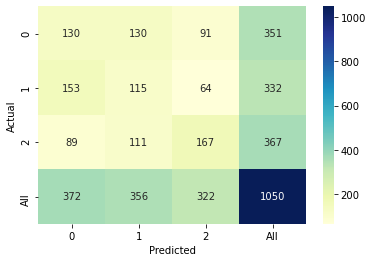

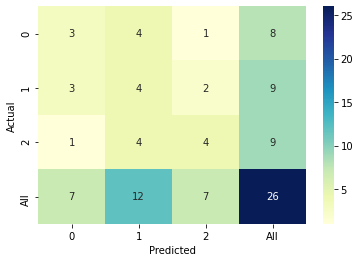

<Figure size 432x288 with 0 Axes>

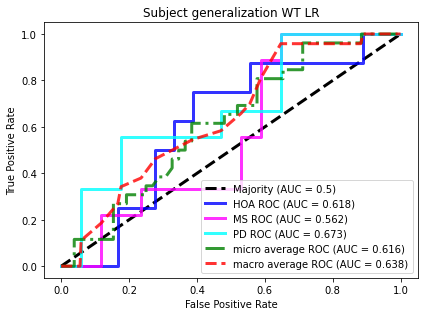

********************************
decision_tree
best_params:  {'decisiontreeclassifier__min_samples_split': 33}

Stride-based model performance (mean):  [0.40234715813253114, 0.42266598172645276, 0.40234715813253114, 0.4478149559405349, [0.3397970771933874, 0.43715896679772825, 0.49104190118824265], 0.4044223971306472, 0.40234715813253114, 0.40234715813253114, [0.34471823507742294, 0.3862251609472451, 0.4823237953672736], 0.3798753815361374, 0.40234715813253114, 0.3882861290950617, [0.3302384461594385, 0.3943152154824401, 0.41507248296653365], 0.5523190659033851, 0.5566715351921601]

Stride-based model performance (standard deviation):  [0.07537333139390408, 0.049230329383219154, 0.07537333139390408, 0.045636891094279104, [0.23269571504390082, 0.2596275299570852, 0.13304377753600485], 0.07074443763246915, 0.07537333139390408, 0.07537333139390408, [0.202543735830551, 0.08574159275997573, 0.3274966461883868], 0.06799079463182563, 0.07537333139390408, 0.06638079876631092, [0.19849072307045

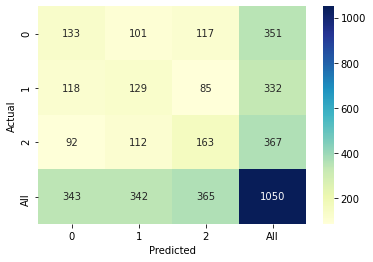

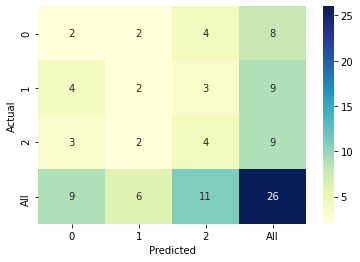

<Figure size 432x288 with 0 Axes>

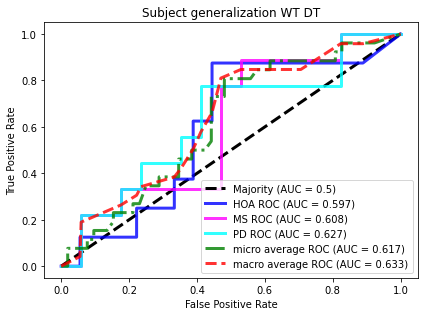

********************************
********************************
feet+ankle
logistic_regression
best_params:  {'logisticregression__random_state': 0}

Stride-based model performance (mean):  [0.37582080008100693, 0.4063079668858235, 0.37582080008100693, 0.4271173429174445, [0.3393859661465295, 0.36566059563360226, 0.5138773388773389], 0.38210775270231084, 0.37582080008100693, 0.37582080008100693, [0.32430624775235606, 0.3204149623757169, 0.5016020479788595], 0.3567747618184972, 0.37582080008100693, 0.3599566217166384, [0.3284826204362268, 0.2928119373417252, 0.44902972767753974], 0.5719903881461263, 0.5767474233433357]

Stride-based model performance (standard deviation):  [0.15437128532324396, 0.1347797957235321, 0.15437128532324396, 0.1257227386985853, [0.29679263948228946, 0.18334160908179292, 0.14239623453717953], 0.15288665752242397, 0.15437128532324396, 0.15437128532324396, [0.24001796505007003, 0.22239227554467622, 0.34802104473504153], 0.16443942668848538, 0.15437128532324396,

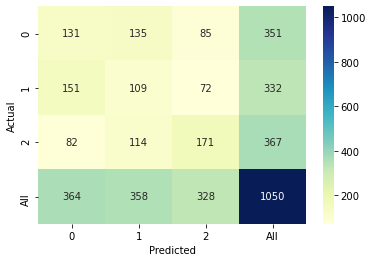

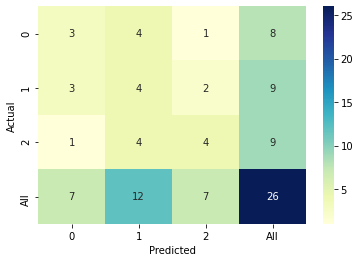

<Figure size 432x288 with 0 Axes>

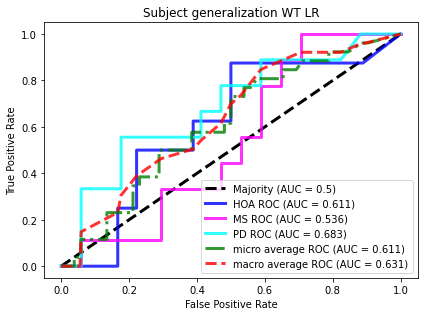

********************************
decision_tree
best_params:  {'decisiontreeclassifier__min_samples_split': 42}

Stride-based model performance (mean):  [0.4068017970111927, 0.42349107333287395, 0.4068017970111927, 0.44892304382418613, [0.3601853461457981, 0.44110401282166667, 0.4691838610311569], 0.41192040154591086, 0.4068017970111927, 0.4068017970111927, [0.37538292737530465, 0.41408817445058593, 0.44629010281184195], 0.38755457866120424, 0.4068017970111927, 0.3941565072873723, [0.35893633547702053, 0.40465662356966703, 0.39907077693692533], 0.5582784004709156, 0.5629232114632213]

Stride-based model performance (standard deviation):  [0.08451419360009998, 0.07191690352541404, 0.08451419360009998, 0.07303014198738311, [0.25492673299165847, 0.27178539661928375, 0.1507186327436872], 0.07999891787243248, 0.08451419360009998, 0.08451419360009998, [0.21340329873235978, 0.06789134026856065, 0.3378631103747997], 0.08666088339300891, 0.08451419360009998, 0.08637083971541626, [0.2227839048509

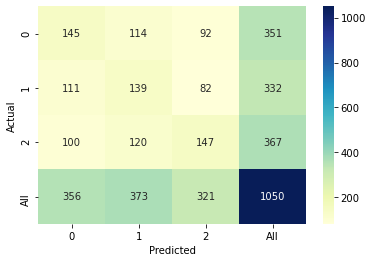

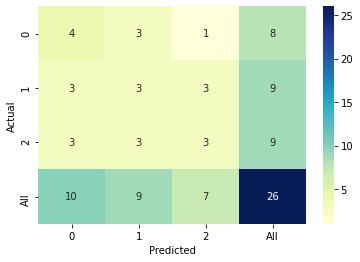

<Figure size 432x288 with 0 Axes>

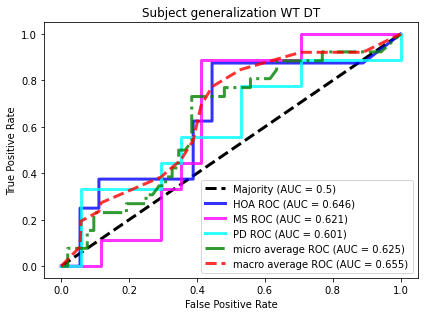

********************************
********************************
feet+ankle+knee
logistic_regression
best_params:  {'logisticregression__random_state': 0}

Stride-based model performance (mean):  [0.40822094423974686, 0.44933138376146686, 0.40822094423974686, 0.4740658290133286, [0.3449946424290736, 0.42964242576261513, 0.5733570830927119], 0.4129251752059259, 0.40822094423974686, 0.40822094423974686, [0.33678017234537166, 0.3656767604320739, 0.536318592840332], 0.39289508139389684, 0.40822094423974686, 0.39883875281261794, [0.3392317084624777, 0.3418983828072262, 0.49755515291198676], 0.6143899374106299, 0.6190837255008839]

Stride-based model performance (standard deviation):  [0.11405402800242123, 0.09211816062263305, 0.11405402800242123, 0.07791321786682333, [0.3077088268754938, 0.24898231357703168, 0.09337192186708045], 0.11132855726732843, 0.11405402800242123, 0.11405402800242123, [0.27148845016782436, 0.1480534585302169, 0.31245981972351317], 0.12233239574745515, 0.114054028002

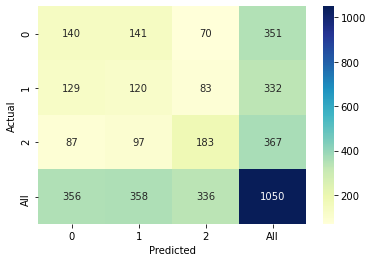

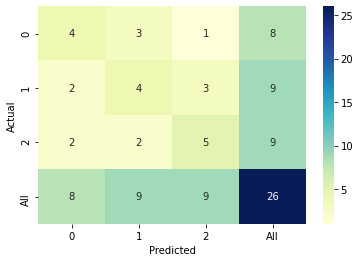

<Figure size 432x288 with 0 Axes>

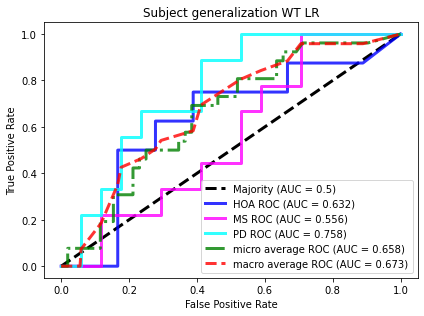

********************************
decision_tree
best_params:  {'decisiontreeclassifier__min_samples_split': 45}

Stride-based model performance (mean):  [0.4664348837587844, 0.4692091798020849, 0.4664348837587844, 0.49394870863056256, [0.3928907730280728, 0.4051565658769289, 0.6095802005012532], 0.4692027152195296, 0.4664348837587844, 0.4664348837587844, [0.45831344890114656, 0.4369201148176427, 0.5123745819397993], 0.44064847060330636, 0.4664348837587844, 0.44725352582760386, [0.41592564061898174, 0.4076878132937624, 0.4983319578971752], 0.58669372427053, 0.5906706481593466]

Stride-based model performance (standard deviation):  [0.055563968763223746, 0.05692299897836774, 0.055563968763223746, 0.0625447311735532, [0.24304862746018213, 0.20925643169649566, 0.14775168195546487], 0.040572351635202085, 0.055563968763223746, 0.055563968763223746, [0.26332535937529894, 0.22377648453492488, 0.25780784625527686], 0.057289784492593566, 0.05556396876322373, 0.06271990719719377, [0.24478723782387

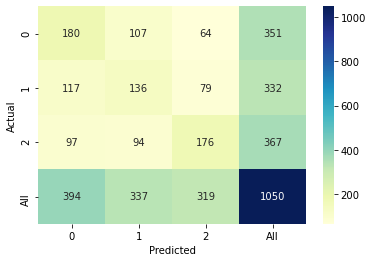

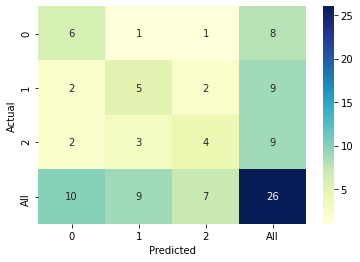

<Figure size 432x288 with 0 Axes>

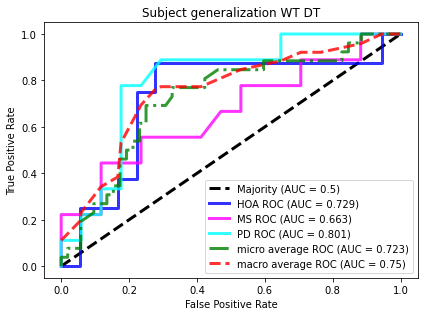

********************************
********************************


In [76]:
for col in datastreams:
    print (col)
    datastream = datastreams[col]
#     print (regressN_trainX_norm[datastream].head())
    stride_person_metrics = run_ml_models(ml_models, X_WT[datastream], Y_WT, framework, results_path, save_results, col)
    for i in stride_person_metrics.columns:
        metrics_WT[(i, col)] = stride_person_metrics[i]
    print ('********************************')

if save_results:
    metrics_WT.to_csv(results_path+ framework + '\\subject_generalize_ablation_study_'+framework+'_result_metrics.csv')

In [77]:
metrics_WT

,"(logistic_regression, feet)","(logistic_regression, feet+ankle)","(logistic_regression, feet+ankle+knee)","(decision_tree, feet)","(decision_tree, feet+ankle)","(decision_tree, feet+ankle+knee)"
stride_accuracy_mean,0.380714,0.375821,0.408221,0.402347,0.406802,0.466435
stride_precision_macro_mean,0.436617,0.406308,0.449331,0.422666,0.423491,0.469209
stride_precision_micro_mean,0.380714,0.375821,0.408221,0.402347,0.406802,0.466435
stride_precision_weighted_mean,0.464861,0.427117,0.474066,0.447815,0.448923,0.493949
stride_precision_class_wise_mean,"[0.3362198685941135, 0.43661303630363035, 0.53...","[0.3393859661465295, 0.36566059563360226, 0.51...","[0.3449946424290736, 0.42964242576261513, 0.57...","[0.3397970771933874, 0.43715896679772825, 0.49...","[0.3601853461457981, 0.44110401282166667, 0.46...","[0.3928907730280728, 0.4051565658769289, 0.609..."
stride_recall_macro_mean,0.389422,0.382108,0.412925,0.404422,0.411920,0.469203
stride_recall_micro_mean,0.380714,0.375821,0.408221,0.402347,0.406802,0.466435
stride_recall_weighted_mean,0.380714,0.375821,0.408221,0.402347,0.406802,0.466435
stride_recall_class_wise_mean,"[0.3334593507585421, 0.3412987686003318, 0.493...","[0.32430624775235606, 0.3204149623757169, 0.50...","[0.33678017234537166, 0.3656767604320739, 0.53...","[0.34471823507742294, 0.3862251609472451, 0.48...","[0.37538292737530465, 0.41408817445058593, 0.4...","[0.45831344890114656, 0.4369201148176427, 0.51..."
stride_F1_macro_mean,0.362063,0.356775,0.392895,0.379875,0.387555,0.440648


### Reading the final metrics from the saved file

In [100]:
ablation_subject_generalizeWT = pd.read_csv(results_path+ framework + '\\subject_generalize_ablation_study_'+framework+'_result_metrics.csv')
ablation_subject_generalizeWT.index = ablation_subject_generalizeWT['Unnamed: 0']
ablation_subject_generalizeWT.drop('Unnamed: 0', axis = 1, inplace = True)

ablation_subject_generalizeWT.columns = [literal_eval(ablation_subject_generalizeWT.loc['person_accuracy_mean'].index[idx]) for idx in range(len(ablation_subject_generalizeWT.loc['person_accuracy_mean'].index))]

In [101]:
ablation_subject_generalizeWT

,"(logistic_regression, feet)","(logistic_regression, feet+ankle)","(logistic_regression, feet+ankle+knee)","(decision_tree, feet)","(decision_tree, feet+ankle)","(decision_tree, feet+ankle+knee)"
Unnamed: 0,,,,,,
stride_accuracy_mean,0.3807142762988591,0.37582080008100693,0.40822094423974686,0.40234715813253114,0.4068017970111927,0.4664348837587844
stride_precision_macro_mean,0.4366167539075473,0.4063079668858235,0.44933138376146686,0.42266598172645276,0.42349107333287395,0.4692091798020849
stride_precision_micro_mean,0.3807142762988591,0.37582080008100693,0.40822094423974686,0.40234715813253114,0.4068017970111927,0.4664348837587844
stride_precision_weighted_mean,0.464860689914065,0.4271173429174445,0.4740658290133286,0.4478149559405349,0.44892304382418613,0.49394870863056256
stride_precision_class_wise_mean,"[0.3362198685941135, 0.43661303630363035, 0.53...","[0.3393859661465295, 0.36566059563360226, 0.51...","[0.3449946424290736, 0.42964242576261513, 0.57...","[0.3397970771933874, 0.43715896679772825, 0.49...","[0.3601853461457981, 0.44110401282166667, 0.46...","[0.3928907730280728, 0.4051565658769289, 0.609..."
stride_recall_macro_mean,0.3894224492169037,0.38210775270231084,0.4129251752059259,0.4044223971306472,0.41192040154591086,0.4692027152195296
stride_recall_micro_mean,0.3807142762988591,0.37582080008100693,0.40822094423974686,0.40234715813253114,0.4068017970111927,0.4664348837587844
stride_recall_weighted_mean,0.3807142762988591,0.37582080008100693,0.40822094423974686,0.40234715813253114,0.4068017970111927,0.4664348837587844
stride_recall_class_wise_mean,"[0.3334593507585421, 0.3412987686003318, 0.493...","[0.32430624775235606, 0.3204149623757169, 0.50...","[0.33678017234537166, 0.3656767604320739, 0.53...","[0.34471823507742294, 0.3862251609472451, 0.48...","[0.37538292737530465, 0.41408817445058593, 0.4...","[0.45831344890114656, 0.4369201148176427, 0.51..."


### Heatmap for person mean accuracy for all algorithms and data streams for Subject generalize in trial WT

In [102]:
person_accuracy_subject_generlaizeWT = pd.DataFrame(columns = ['random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'decision_tree',  'linear_svm', 
             'logistic_regression', 'mlp'], index = list(datastreams.keys()))


for idx in range(len(ablation_subject_generalizeWT.columns)):
    x = ablation_subject_generalizeWT.loc['person_accuracy_mean'].index[idx][1]
    y = ablation_subject_generalizeWT.loc['person_accuracy_mean'].index[idx][0]
#     print (regressN_metrics.loc['person_accuracy'][(y, x)])
    person_accuracy_subject_generlaizeWT.loc[x, y] = ablation_subject_generalizeWT.loc['person_accuracy_mean'][(y, x)]

person_accuracy_subject_generlaizeWT = person_accuracy_subject_generlaizeWT.astype(float)

In [103]:
#Adding the person mean accuracy for all the models using all the features 
person_accuracy_subject_generlaizeWT.loc['All features'] = [np.nan]*9

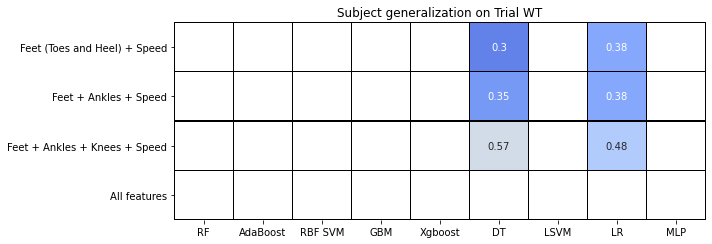

In [104]:
ml_model_names1 = ['RF','AdaBoost', 'RBF SVM', 'GBM','Xgboost', 'DT',  'LSVM', 'LR', 'MLP']
datasets = ['Feet (Toes and Heel) + Speed', 'Feet + Ankles + Speed', 'Feet + Ankles + Knees + Speed', 'All features']

fig, axes = plt.subplots(1, 1, figsize=(10, 3.5))
sns.heatmap(person_accuracy_subject_generlaizeWT, vmin=0.3, vmax=1.0, center = 0.6, cmap="coolwarm", annot=True, linewidths=0.4, linecolor="k", \
            cbar = False, xticklabels=ml_model_names1,  yticklabels=datasets)
plt.title('Subject generalization on Trial WT')
plt.tight_layout()
plt.savefig(results_path + framework + '\\subject_generalize_ablation_study_'+framework+'_heatmap.jpg', dpi = 250)
plt.show()